# Example: reading corrected AGIPD data an plotting radial profile #

This example will shows how to read corrected AGIPD data, assuring data from all modules is present for a given train. It processes a defined number of trains into a a per-pixel maxium value image. From this data a radial profile is processed. 

In [1]:
# turn off warnings for presentation purposes
import warnings
warnings.filterwarnings('ignore')

# numpy and matplotlib
import numpy as np
import matplotlib 
matplotlib.use("agg")
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
%matplotlib inline

# these are European XFEL specific hdf5 tools
from euxfel_h5tools import (RunHandler, stack_data)

# the run we will be looking at
RUNPATH = "/gpfs/exfel/data/scratch/haufs/karabo_ws/r0803/"

In [2]:
# load run and train data
run = RunHandler(RUNPATH)
trains = run.trains()

In [3]:
# trains is a generator, wie can thus iterate over it, or get the next
# value using `next`
first_train = next(trains)
print("Train id: {}".format(first_train[0]))

Train id: 1541484692


In [4]:
# in the following we will be using image data, gain encoding and
# the bad pixel mask
data_stacks = []
gain_stacks = []
mask_stacks = []

# we will work on 5 trains
i = 0
for train in trains:
    
    tid, all_data = train
    
    # stack data gets us data from all detector module with image.data 
    # entries for a given train
    data = stack_data(all_data, 'image.data')
    
    # we only want trains with the full detector (16 modules) present;
    # if we have less we try the next train
    if data.shape[1] != 16:
        continue
    data_stacks.append(data)
    
    # we do the same for gain data and bad pixel mask data
    gain = stack_data(all_data, 'image.gain')
    gain_stacks.append(gain)
    
    mask = stack_data(all_data, 'image.mask')
    mask_stacks.append(mask)
    
    # 5 trains is enough for the example. I we wouldn' break here, we
    # would iterate over all trains in the run
    if i == 5:
        break
        
    i += 1

# finally concatenate the data along its image axis to have stacks of the
# images of five trains
comb_data = np.concatenate(data_stacks, axis=0)
comb_gain = np.concatenate(gain_stacks, axis=0)

# the mask has an additional gain dimension. we harmonize the data layout to
# have pixels dimensions at the end
comb_mask = np.moveaxis(np.concatenate(mask_stacks, axis=0), 2, 1)

In [5]:
def plot_stack(d, coord_list, stack_dim=0):
    """ Plot data from multiple modules as defined by a coordinate list
    """
    fig = plt.figure(figsize=(10,10))
    x = np.arange(d.shape[1])
    y = np.arange(d.shape[2])
    Y, X = np.meshgrid(y, x)    
    for i in range(d.shape[stack_dim]):
        x0, y0, mx, my = coord_list[i]
        ax0 = x0/d.shape[1]/2. # two columns of modules
        ay0 = y0/d.shape[2]/8. # eight rows of modules
        ax = fig.add_axes((ax0, ay0, 1./2, 1./8)) # mod. axes scaled to 1/16
        
        # AGIPD data has a high dynamic range. Using a power norm with an
        # appropriate gamma value we can visualize features accross this
        # range better than with linear or log scaling.
        pcm = ax.pcolormesh(X, Y, d[i,::my,::mx],
                            norm=PowerNorm(vmin=1, vmax=250000, gamma=0.3))
        ax.set_aspect(1) # AGIPD has square pixels
        ax.set_xlim(0, 512)
        ax.set_ylim(0, 128)
    return fig

In [6]:
# here we mask bad pixels. The mask is a bit mask, where non-zero values
# indicate some form of masking. Values above 128 indicate values below
# five sigma noise.
msk = np.choose(comb_gain, (comb_mask[...,0], comb_mask[...,1], comb_mask[...,2]))
comb_data[(msk > 0) & (msk < 128)] = np.nan

# we will also only use data from memory cells which actually contained FEL pulses
# first 4 cells do not contain pulses:
for i in range(4):
    comb_data[i::64,...] = np.nan
# then only every second cell contains pulses
comb_data[1::2,...] = np.nan

# we will take the maximum per pixel value which should make also less intense
# features visible. We limit ourselves to the first cell containing a FEL pulse
d = np.nanmax(comb_data[4::64,...], axis=0)

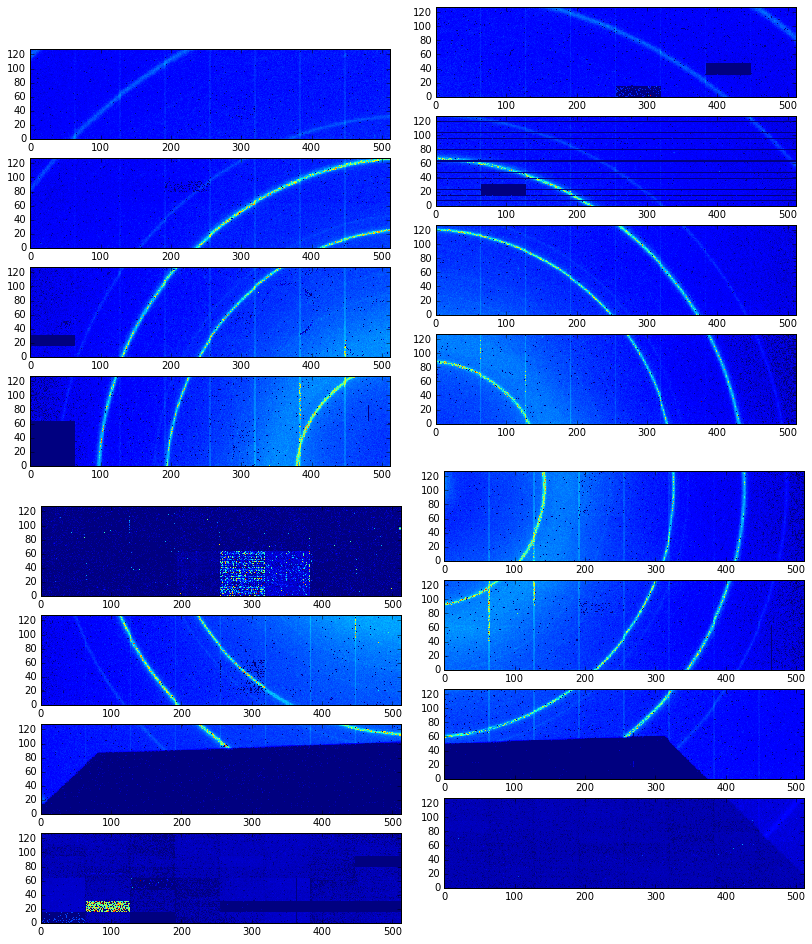

In [7]:
# define an approximate coordinate list for the modules
coord_list = []
for i in range(4):
    coord_list.append((25, -i*(128+27)+35, -1, -1))
for i in range(4,8):
    coord_list.append((37, -i*(128+27)-5, -1, -1))
for i in range(4,8):
    coord_list.append((-537, -i*(128+27)-55, 1, 1))
for i in range(4):
    coord_list.append((-552, -i*(128+27)-25, 1, 1))

# and plot an overview of the data
fig = plot_stack(d, coord_list)

In [15]:
# the ASIC edges have double sized pixels and thus see more photons
# on average. For the following we ignore them.
def filter_asic_edges(d):
    """ Set ASIC edge pixels to zero
    """
    d[0::64,...] = 0
    d[63::64,...] = 0
    return d

# convert the Carthesian coordinates of the detector to polar coordinates
def mod_cart_to_pol(d, dx, dy):
    """ Convert carthesian coords to polar coords
    """
    cx, cy = d.shape
    x = np.arange(cx)+dx
    y = np.arange(cy)+dy
    x = np.repeat(x[:,None], cy, axis=1)
    y = np.repeat(y[None,:], cx, axis=0)
    
    rho = np.sqrt(x**2 + y**2).flatten()
    phi = np.arctan2(y, x).flatten()
    flat = d.flatten()
    
    # we also perform a bit of filtering here
    good = np.isfinite(flat) & (flat > 0) & (flat < 1e6)
        
    return rho[good], phi[good], flat[good]

In [16]:
# Here we create histograms of the data in a polar coordinate system.
# We use numpys hist2d function, giving it the polar coordinates of 
# each pixels, and weighing that coordinate with the pixel's value.
# We obtain a histogram for each module, according to its position defined
# in the coord_list.
hs = []
for i in range(16):    
    dx, dy, mx, my = coord_list[i]
    td = filter_asic_edges(d[i,::my,::mx])
    # module 8 is completely shadowed and module 11 did not have
    # HV enabled in this campaign.
    if i == 8 or i == 11:
        td = np.zeros_like(d[i-1])
    # add 512 to y coords because coord_list starts at top edge, but 
    # polar coordinates are centered on beam.
    rho, phi, weights = mod_cart_to_pol(td, dx, 512+dy)
    h, phi_edges, rho_edges = np.histogram2d(phi, rho, bins=(500,500),
                                             range=((-np.pi, np.pi), (0, 1000)),
                                             weights=weights)
    hs.append(h)

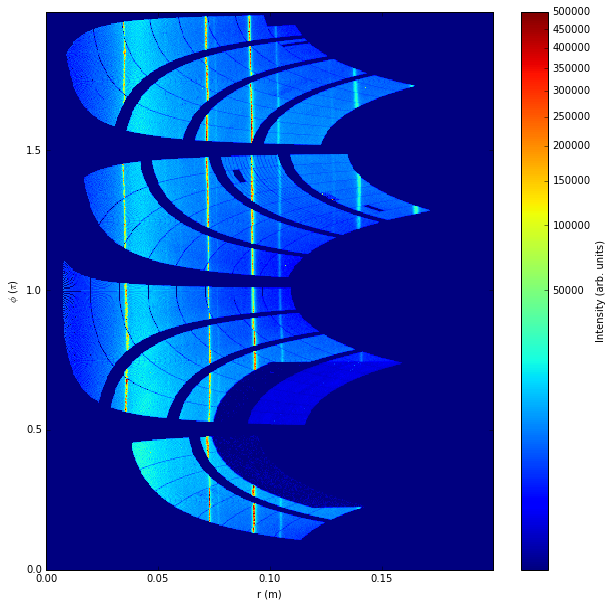

In [17]:
# Plot data in polar coordinates. Diffraction rings should now show as vertical
# lines, connected over all modules - if the positions in the coordinate list
# are indeed correct that is.
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
x = np.arange(500)/500*1000*200e-6
y = np.arange(500)/500*2.
ds = np.array(hs).sum(axis=0)
im = plt.pcolormesh(x, y, ds, norm=PowerNorm(vmin=1, vmax=5e5, gamma=0.3))
cb = fig.colorbar(im)
ax.set_xlim(0, np.max(x))
ax.set_ylim(np.min(y), np.max(y))
ax.set_xlabel("r (m)")
ax.set_ylabel("$\phi$ ($\pi$)")
cb.set_label("Intensity (arb. units)")

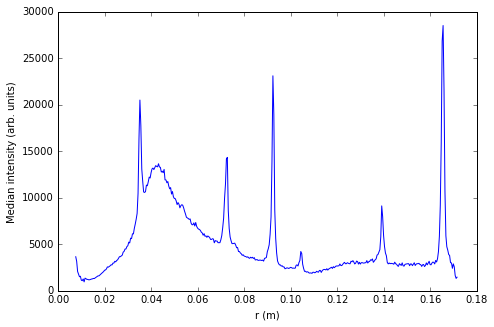

In [20]:
# With appropriate coordinates given, plotting a profile along the
# vertical axis should give us the positions of the diffraction peaks,
# Here still as distances on the detector plane. With knowledge of the
# detector to sample distance, these could then be converted in 
# reciprocal coordinates.
ds[ds == 0] = np.nan
profile = np.nanmedian(ds, axis=0)
fig = plt.figure(figsize=(7.5,5))
ax = fig.add_subplot(111)
ax.plot(x, profile)
ax.set_xlabel("r (m)")
ax.set_ylabel("Median intensity (arb. units)")